# Execution

This notebook explains how PartiQL executes, with some discussion of its implementation.

## Data model

As discussed in [02-data-model.ipynb](02-data-model.ipynb), the only allowed types are PLURP (PLUR in this demo). In a rowwise, dynamically typed interpreter, this means there are only values, records, and lists. Since PartiQL is list order-independent and merges items with the same key, the lists are really sets, though the word "list" appears in the implementation and error messages.

Every value entering or exiting the PartiQL interpreter is a `data.Instance`, even simple numbers.

In [35]:
import data

arrays = data.RecordArray({
    "x": data.PrimitiveArray([0.1, 0.2, 0.3]),
    "y": data.PrimitiveArray([1000, 2000, 3000]),
    "table1": data.ListArray([0, 3, 3], [3, 3, 5], data.RecordArray({
            "a": data.PrimitiveArray([1.1, 2.2, 3.3, 4.4, 5.5]),
            "b": data.PrimitiveArray([100, 200, 300, 400, 500])
        })
    ),
    "table2": data.ListArray([0, 2, 3], [2, 3, 8], data.RecordArray({
            "b": data.PrimitiveArray([True, False, True, False, False, True, True, True]),
            "c": data.PrimitiveArray([10, 20, 100, 1, 2, 3, 4, 5])
        })
    ),
    "stuff": data.ListArray([0, 3, 3], [3, 3, 5], data.PrimitiveArray([1, 2, 3, 4, 5]))
})

arrays.tolist()

[{'x': 0.1,
  'y': 1000,
  'table1': [{'a': 1.1, 'b': 100}, {'a': 2.2, 'b': 200}, {'a': 3.3, 'b': 300}],
  'table2': [{'b': True, 'c': 10}, {'b': False, 'c': 20}],
  'stuff': [1, 2, 3]},
 {'x': 0.2,
  'y': 2000,
  'table1': [],
  'table2': [{'b': True, 'c': 100}],
  'stuff': []},
 {'x': 0.3,
  'y': 3000,
  'table1': [{'a': 4.4, 'b': 400}, {'a': 5.5, 'b': 500}],
  'table2': [{'b': False, 'c': 1},
   {'b': False, 'c': 2},
   {'b': True, 'c': 3},
   {'b': True, 'c': 4},
   {'b': True, 'c': 5}],
  'stuff': [4, 5]}]

In [36]:
arrays.setindex()

instances = data.instantiate(arrays)
instances

List{ 
    Rec#3(0){ 
        x = Value#3(0){ 0.1 }
        y = Value#3(0){ 1000 }
        table1 = List#3(0){ 
            Rec#4(0 0){ 
                a = Value#4(0 0){ 1.1 }
                b = Value#4(0 0){ 100 }
            }
            Rec#4(0 1){ 
                a = Value#4(0 1){ 2.2 }
                b = Value#4(0 1){ 200 }
            }
            Rec#4(0 2){ 
                a = Value#4(0 2){ 3.3 }
                b = Value#4(0 2){ 300 }
            }
        }
        table2 = List#3(0){ 
            Rec#5(0 0){ 
                b = Value#5(0 0){ True }
                c = Value#5(0 0){ 10 }
            }
            Rec#5(0 1){ 
                b = Value#5(0 1){ False }
                c = Value#5(0 1){ 20 }
            }
        }
        stuff = List#3(0){ 
            Value#6(0 0){ 1 }
            Value#6(0 1){ 2 }
            Value#6(0 2){ 3 }
        }
    }
    Rec#3(1){ 
        x = Value#3(1){ 0.2 }
        y = Value#3(1){ 2000 }
        table1 = List#3(1){ 
    

## Inputs and outputs

Next, we'll run a few simple examples to show what the runtime engine requires and produces.

If you have not already done so, install the [Lark parser](https://github.com/lark-parser/lark#readme) and Matplotlib.

In [6]:
!pip install lark-parser matplotlib

In [3]:
import interpreter

The interpreter takes a source string and a `data.ListInstance` of `data.RecordInstances` as input.

It returns any newly assigned variables (as a `data.ListInstance` of `data.RecordInstances`) and the hierarchy of counters, which may be a single counter (total number of events) or a directory of histograms.

In [4]:
output, counter = interpreter.run(r"""

z = x + 1

hist z by regular(100, 1, 1.5) named "h"

""", instances)

In [5]:
output

List{ 
    Rec#0(0){ 
        z = Value#0(0){ 1.1 }
    }
    Rec#0(1){ 
        z = Value#0(1){ 1.2 }
    }
    Rec#0(2){ 
        z = Value#0(2){ 1.3 }
    }
}

In [6]:
counter.allkeys()

['h']

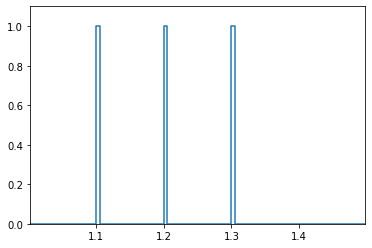

In [7]:
counter["h"].mpl()

Variables assigned in nested blocks will *not* be returned, but histograms defined in these blocks will.

In [8]:
output, counter = interpreter.run(r"""

table1 with {
    z = a + 1
    hist z by regular(100, 0, 10) named "h"
}

""", instances)

In [9]:
output

List{ 
}

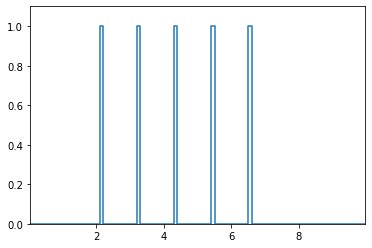

In [10]:
counter["h"].mpl()

To get nested quantities as output, be sure to assign them to a top-level variable.

In [11]:
output, counter = interpreter.run(r"""

top = table1 with {
    z = a + 1
    hist z by regular(100, 0, 10) named "h"
}

""", instances)

In [12]:
output

List{ 
    Rec#0(0){ 
        top = List#0(0){ 
            Rec#1(0 0){ 
                a = Value#1(0 0){ 1.1 }
                b = Value#1(0 0){ 100 }
                z = Value#1(0 0){ 2.1 }
            }
            Rec#1(0 1){ 
                a = Value#1(0 1){ 2.2 }
                b = Value#1(0 1){ 200 }
                z = Value#1(0 1){ 3.2 }
            }
            Rec#1(0 2){ 
                a = Value#1(0 2){ 3.3 }
                b = Value#1(0 2){ 300 }
                z = Value#1(0 2){ 4.3 }
            }
        }
    }
    Rec#0(1){ 
        top = List#0(1){ 
        }
    }
    Rec#0(2){ 
        top = List#0(2){ 
            Rec#1(2 0){ 
                a = Value#1(2 0){ 4.4 }
                b = Value#1(2 0){ 400 }
                z = Value#1(2 0){ 5.4 }
            }
            Rec#1(2 1){ 
                a = Value#1(2 1){ 5.5 }
                b = Value#1(2 1){ 500 }
                z = Value#1(2 1){ 6.5 }
            }
        }
    }
}

Variables assigned at the top-level of the source are a functional return value, but histograms and counters are a side-effect.

Histograms nested in a `cut` or `vary` are nested in their counters.

In [23]:
output, counter = interpreter.run(r"""
cut x > 0.1 named "c" {
    table2 with {
        hist c by regular(100, 0, 10) named "h"
    }
}
""", instances)

In [24]:
counter.allkeys()

['c', 'c/h']

In [25]:
counter["c"]

<DirectoryCounter 2 (2.0 +- 1.4142135623730951)>

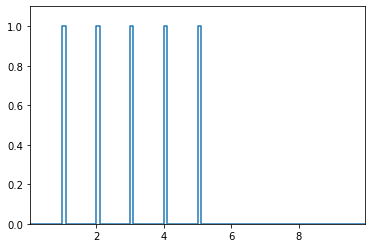

In [27]:
counter["c/h"].mpl()

## Scalar expressions

Trivial assignment is one way to pass on values from intput to output.

In [28]:
output, counter = interpreter.run(r"""

x = x

""", instances); output

List{ 
    Rec#0(0){ 
        x = Value#0(0){ 0.1 }
    }
    Rec#0(1){ 
        x = Value#0(1){ 0.2 }
    }
    Rec#0(2){ 
        x = Value#0(2){ 0.3 }
    }
}

Missing values are handled as unions of records with a field with records without that field. They're only passed through an expression if safe navigation operators (`?`) are used (or explicit checks for `has`).

In [30]:
output, counter = interpreter.run(r"""

a = if x > 0.1 then 100

b = if x > 0.1 then 100 else 200

c = ?a

d = if has a then 100 else 200

""", instances); output

List{ 
    Rec#0(0){ 
        b = Value{ 200 }
        d = Value{ 200 }
    }
    Rec#0(1){ 
        a = Value{ 100 }
        b = Value{ 100 }
        c = Value{ 100 }
        d = Value{ 100 }
    }
    Rec#0(2){ 
        a = Value{ 100 }
        b = Value{ 100 }
        c = Value{ 100 }
        d = Value{ 100 }
    }
}

Temporary variables don't appear if they're in a curly-brackets scope.

In [31]:
output, counter = interpreter.run(r"""

a = {
    tmp1 = x + 1
    tmp2 = x * 100
    tmp2**2
}

""", instances); output

List{ 
    Rec#0(0){ 
        a = Value#0(0){ 100.0 }
    }
    Rec#0(1){ 
        a = Value#0(1){ 400.0 }
    }
    Rec#0(2){ 
        a = Value#0(2){ 900.0 }
    }
}

## Table (set of records) expressions

The `as` operator turns any set into a set of records nested within a single field.

In the example below, `out1` does not have a record structure, but `out2` does—the same data is packed in a field named `nested`.

In [37]:
output, counter = interpreter.run(r"""

out1 = stuff
out2 = stuff as nested

""", instances); output

List{ 
    Rec#3(0){ 
        out1 = List#3(0){ 
            Value#6(0 0){ 1 }
            Value#6(0 1){ 2 }
            Value#6(0 2){ 3 }
        }
        out2 = List#3(0){ 
            Rec#6(0 0){ 
                nested = Value#6(0 0){ 1 }
            }
            Rec#6(0 1){ 
                nested = Value#6(0 1){ 2 }
            }
            Rec#6(0 2){ 
                nested = Value#6(0 2){ 3 }
            }
        }
    }
    Rec#3(1){ 
        out1 = List#3(1){ 
        }
        out2 = List#3(1){ 
        }
    }
    Rec#3(2){ 
        out1 = List#3(2){ 
            Value#6(2 0){ 4 }
            Value#6(2 1){ 5 }
        }
        out2 = List#3(2){ 
            Rec#6(2 0){ 
                nested = Value#6(2 0){ 4 }
            }
            Rec#6(2 1){ 
                nested = Value#6(2 1){ 5 }
            }
        }
    }
}

It is also a special case of sampling without replacement.

In [38]:
output, counter = interpreter.run(r"""

out1 = stuff as (x, y)

""", instances); output

List{ 
    Rec#3(0){ 
        out1 = List#3(0){ 
            Rec#6*#6(0 0){ 
                x = Value#6(0 0){ 1 }
                y = Value#6(0 1){ 2 }
            }
            Rec#6*#6(0 1){ 
                x = Value#6(0 0){ 1 }
                y = Value#6(0 2){ 3 }
            }
            Rec#6*#6(0 2){ 
                x = Value#6(0 1){ 2 }
                y = Value#6(0 2){ 3 }
            }
        }
    }
    Rec#3(1){ 
        out1 = List#3(1){ 
        }
    }
    Rec#3(2){ 
        out1 = List#3(2){ 
            Rec#6*#6(2 0){ 
                x = Value#6(2 0){ 4 }
                y = Value#6(2 1){ 5 }
            }
        }
    }
}